In [1]:
import pandas as pd
import pathlib
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pickle
%matplotlib widget

# Imports own modules.
# All imports are done relative to the root of the project.
#
root_dir = pathlib.Path('../')
sys.path.append(root_dir)


In [12]:
# Get the dataset as follows:
#

# !wget https://data.london.gov.uk/download/smartmeter-energy-use-data-in-london-households/04feba67-f1a3-4563-98d0-f3071e3d56d1/Partitioned%20LCL%20Data.zip
# !unzip 'Partitioned LCL Data.zip'


In [13]:
# Read in all csv files into one dataFrame
#

df = pd.DataFrame()
raw_data_dir = pathlib.Path(root_dir, 'data/raw/London_smartmeter_data')
csv_files = raw_data_dir.glob('*.csv')
for csv_file in tqdm(csv_files):
    df_temp = pd.read_csv(
        csv_file,
        parse_dates=['DateTime'],
    )
    df = pd.concat([df, df_temp])


0it [00:00, ?it/s]


In [4]:
pickle_path = pathlib.Path(root_dir, 'data/raw/london_households_raw.pkl')
# df.to_pickle(pickle_path)
df = pd.read_pickle(pickle_path)
df


FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/london_households_raw.pkl'

In [14]:
# Do some further preprocessing of the household data
#

# Set the timezone
df['DateTime'] = df['DateTime'].dt.tz_localize('UTC')

# Filter out the time-of-use customers
df = df[df["stdorToU"] == 'Std']
df = df.drop(columns=['stdorToU'])

# Cast the power from 'object' to 'float'
df['KWH/hh (per half hour) '] = pd.to_numeric(df['KWH/hh (per half hour) '], errors='coerce')
df

# Scale the load profile to [W].
# Multiplicator, to come from [KWH/hh (per half hour)] to [W]
# = 10000 * (energy / (1/2 h))  * (1/2 h)
df['power'] = df['KWH/hh (per half hour) '] * 10000 / 2
df = df.drop(columns=['KWH/hh (per half hour) '])

# Change the shape of the dataframe from (num_of_timesteps * num_of_households)
# to (num_of_timesteps, num_of_households).
df = df.pivot_table(index='DateTime', columns='LCLid', values='power', aggfunc='first')

# Downsample from 30min frequency to 1h frequency
df = df.resample('1h').mean() 
df

LCLid,MAC000002,MAC000003,MAC000004,MAC000006,MAC000007,MAC000008,MAC000009,MAC000010,MAC000011,MAC000012,...,MAC005548,MAC005552,MAC005553,MAC005554,MAC005555,MAC005558,MAC005561,MAC005562,MAC005566,MAC005567
DateTime,,,,,,,,,,,,,,,,,,,,,
2011-11-23 09:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-23 10:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-23 11:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-23 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-23 13:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-27 20:00:00+00:00,5647.50000,1540.0,97.5,570.0,952.5,NaN,1180.0,5090.0,1480.0,27.5,...,930.0,1960.0,9677.50025,NaN,760.0,0.0,2087.5,1892.5,755.0,265.0
2014-02-27 21:00:00+00:00,2500.00000,425.0,0.0,662.5,1100.0,NaN,1052.5,2662.5,1260.0,47.5,...,497.5,4762.5,9050.00000,NaN,805.0,0.0,1870.0,1827.5,792.5,322.5
2014-02-27 22:00:00+00:00,4415.00000,397.5,417.5,285.0,1570.0,NaN,1327.5,2530.0,790.0,260.0,...,282.5,1552.5,6770.00000,NaN,452.5,0.0,1122.5,1907.5,660.0,945.0


In [12]:
pickle_path = pathlib.Path(root_dir, 'data/london_households.pkl')
# df.to_pickle(pickle_path)
df = pd.read_pickle(pickle_path)


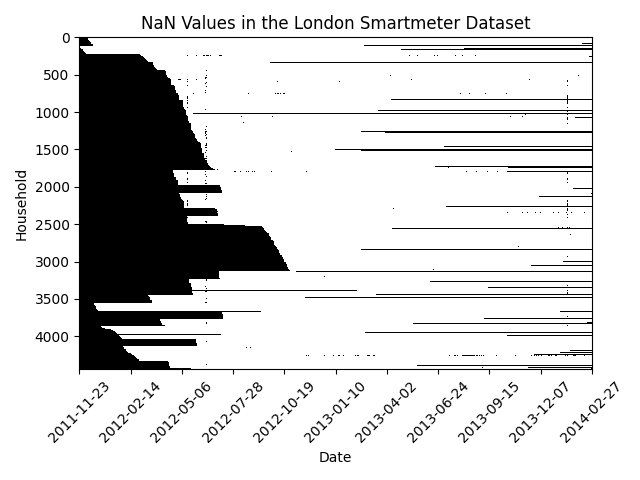

In [3]:
# Create a mask DataFrame where True indicates NaN value
nan_mask = df.isna().T

# Plot the NaN values using a heatmap
plt.figure()
plt.imshow(nan_mask, aspect='auto', cmap='binary', interpolation='none')
plt.title('NaN Values in the London Smartmeter Dataset')
plt.xlabel('Date')
plt.ylabel('Household')

# Customize x-axis ticks with dates
timesteps = df.index  # Get the index containing dates
tick_locations = range(0, len(timesteps), max(1, len(timesteps) // 10))  # Adjust tick frequency
tick_labels = [timesteps[i].strftime('%Y-%m-%d') for i in tick_locations]

plt.xticks(tick_locations, tick_labels, rotation=45)  # Rotate for better readability
plt.grid(False)
plt.tight_layout()
plt.savefig("../scripts/outputs/figs/nan_values_in_dataset.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()



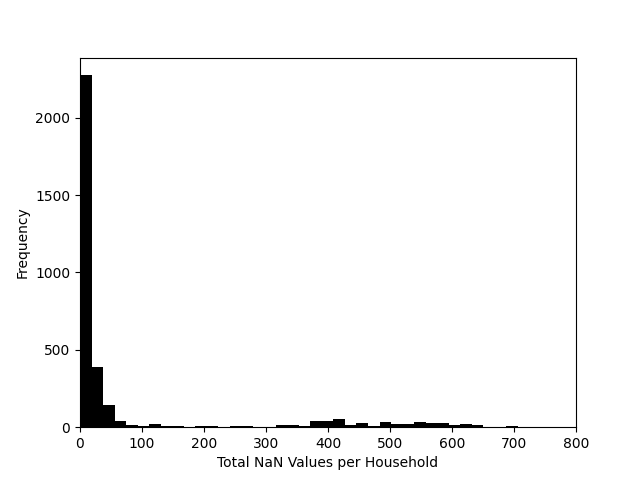

In [15]:
plt.figure()
first_timestamp = 5000
first_timestamp_date = timesteps[first_timestamp].strftime('%Y-%m-%d')
nan_sum_per_column = df[first_timestamp:].isnull().sum()  # Calculate sum of NaN values per household
nan_sum_per_column.hist(bins=800, color='black')  # Plot histogram
plt.xlabel('Total NaN Values per Household')
plt.ylabel('Frequency')
# plt.title(f'Histogram of summed up NaN Values\n per Household after {first_timestamp_date}')
plt.xlim(0, 800)
plt.grid(False)
plt.savefig("../scripts/outputs/figs/nan_values_histogram.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()


In [5]:
# Generate further power profiles from random communities
num_of_communities = 20
community_sizes = [1, 2, 10, 50, 100]

# Set seed for reproducibility
np.random.seed(0)

for community_size in community_sizes:

    # Choose only households with a reasonable amount of NaN values
    columns_few_nan = df[first_timestamp:].columns[df[first_timestamp:].isna().sum() < 50]
    random_columns = np.random.choice(columns_few_nan, size=(num_of_communities, community_size), replace=False)

    powerProfiles = []
    for community_id in range(num_of_communities):

        # Aggregate those power values. NaN values are skipped, i.e. set to 0.
        powerProfile = df[random_columns[community_id,:]].iloc[first_timestamp:].sum(axis=1, skipna=True)
        powerProfile.name = 'Aggregated_Power'
        powerProfiles.append(powerProfile)

    # Store the load profile
    pickle_path = pathlib.Path(root_dir, f'data/london_loadprofiles_{community_size}households_each.pkl')
    with open(pickle_path, 'wb') as file:
        pickle.dump(powerProfiles, file)


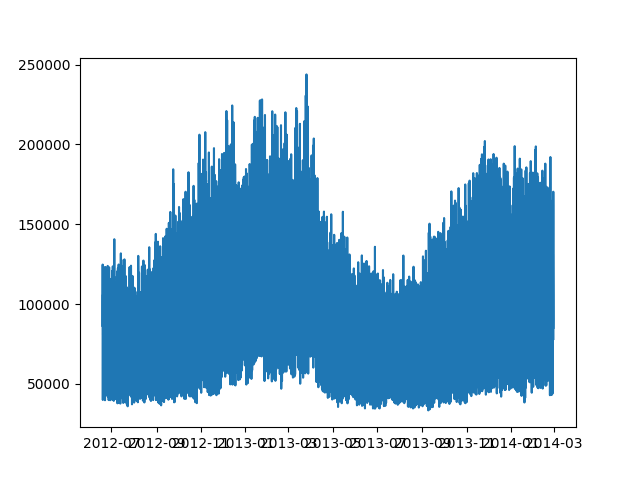

In [6]:
plt.figure()
plt.plot(powerProfiles[15])
plt.show()
